<a href="https://colab.research.google.com/github/Bakarime27/app-sante-public/blob/main/segmentation_olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Segmentez des clients d'un site e-commerce**
Ce projet a pour but d'effectuer une segmentation des clients d'Olist (un site d'e-commerce) afin que ses équipes marketing puissent s'en servir dans leurs campagnes de communication.

Notre mission est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons fournir une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous allons également fournir une analyse de la stabilité des segments au cours du temps afin d'établir un contrat de maintenance.


### **1.&nbsp;Segmentation avec le dataset rfm**

### **1.1.&nbsp;Chargement des données**

In [ ]:
from google.colab import drive
#drive.mount("/gdrive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Datasets
%ls

Mounted at /gdrive
/gdrive/MyDrive/Datasets
2016_Building_Energy_Benchmarking.csv  olist_order_payments_dataset.csv
clean-data.csv                         olist_order_reviews_dataset.csv
fr.openfoodfacts.org.products.csv      olist_orders_dataset.csv
house.csv                              olist_products_dataset.csv
olist_customers_dataset.csv            olist-rfm.csv
olist-customers-segmentation.csv       olist_sellers_dataset.csv
olist_geolocation_dataset.csv          product_category_name_translation.csv
olist_order_items_dataset.csv          sea-clean-data.csv


In [ ]:
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from datetime import datetime
from datetime import timedelta
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
#from kmodes.kprototypes import KPrototypes
from math import radians, cos, sin, asin, sqrt

In [ ]:
data_rfm = pd.read_csv('olist-rfm.csv', index_col=0)

In [ ]:
''' data_rfm.drop(['Unnamed: 0'], axis=1, inplace=True) '''

" data_rfm.drop(['Unnamed: 0'], axis=1, inplace=True) "

In [ ]:
data_rfm.head()

,customer_unique_id,r_score,f_score,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,27.19
2,0000f46a3911fa3c0805444483337064,536.0,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,320.0,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,287.0,1,196.89


In [ ]:
''' data_rfm.drop(['customer_unique_id'], axis=1, inplace=True) '''

" data_rfm.drop(['customer_unique_id'], axis=1, inplace=True) "

In [ ]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  96096 non-null  object 
 1   r_score             93357 non-null  float64
 2   f_score             96096 non-null  int64  
 3   m_score             93357 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [ ]:
# Find features to fill and fillna with mode
features_to_fill = data_rfm.isnull().sum()
features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)

for f in features_to_fill:
    data_rfm[f] = data_rfm[f].fillna(data_rfm[f].mode()[0])
    print(f, data_rfm[f].mode()[0])

r_score 277.0
m_score 77.57


In [ ]:
numerical_features = list(data_rfm.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['r_score', 'f_score', 'm_score']

### **1.2.&nbsp;Application de Kmeans**

In [ ]:
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

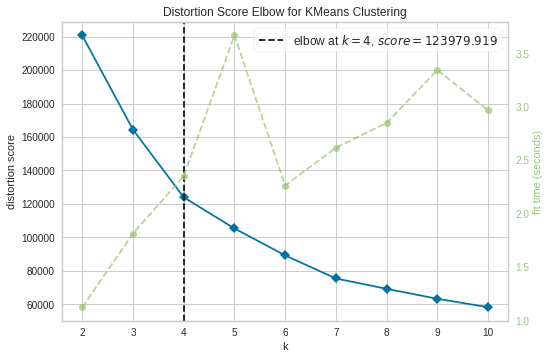

In [ ]:
X_rfm = data_rfm.copy()

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X_rfm)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

In [ ]:
X_rfm.shape

(96096, 4)

In [ ]:
X_rfm.head()

,customer_unique_id,r_score,f_score,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,27.19
2,0000f46a3911fa3c0805444483337064,536.0,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,320.0,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,287.0,1,196.89


Grâce à la méthode du coude basée sur le score de distortion (somme moyenne des carrés des distances aux centres), une segementation en K=4 clusters serait la meilleure option.

Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster.  
Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

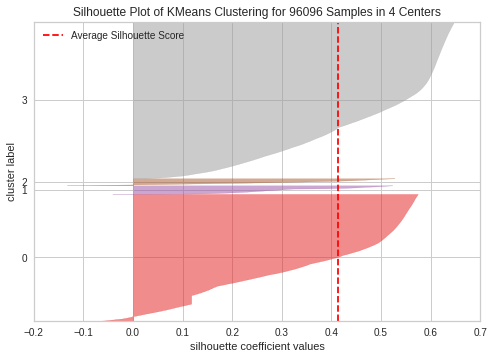

In [ ]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X_rfm)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Les clusters sont relativement bien répartis et les séparations sont claires 

Nous allons maintenant calculer les distances intercluster

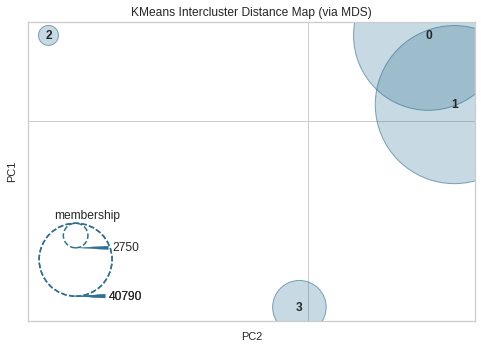

In [ ]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X_rfm)
distance_visualizer.named_steps['distancevisualizer'].show()

Nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :

In [ ]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X_rfm)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data_rfm["kmeans_label"] = kmeans_labels

Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :

In [ ]:
kmeans_clusters_means = data_rfm.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,r_score,f_score,m_score
0,0,239.616946,1.162842,1155.242207
1,1,377.062347,1.014465,126.106330
2,2,125.768074,1.104589,132.138252
3,3,229.338545,3.865091,285.345940


boxplot par categorie (par label)

In [ ]:
''' X_rfm_scaled = preprocessor.fit_transform(X_rfm) '''

In [ ]:
''' X_rfm.shape '''

(96096, 4)

In [ ]:
X_rfm_scaled = preprocessor.fit_transform(X_rfm)
X_rfm_scaled = pd.DataFrame(X_rfm_scaled, index=X_rfm.index, columns=numerical_features)
X_rfm_scaled["kmeans_label"] = kmeans_labels
X_rfm_scaled_clusters = X_rfm_scaled.groupby("kmeans_label").mean()
X_rfm_scaled_clusters

,r_score,f_score,m_score
kmeans_label,,,
0,0.010219,0.025106,4.594985
1,0.923229,-0.205771,-0.147374
2,-0.746046,-0.065537,-0.119578
3,-0.058058,4.229844,0.586418


Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Plotly pour visualiser les différences entre cluster :

In [ ]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))
    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [ ]:
plot_radars(data=X_rfm_scaled_clusters,
            group="kmeans_label")

**Interpretation**

### **2.&nbsp;Segmentation avec le dataset global**

### **2.1.&nbsp;Chargement des données**

Nous allons suivre la même procédure que dans la section précédente mais cette fois avec le dataset global

In [ ]:
data = pd.read_csv('olist-customers-segmentation.csv', index_col=0)

In [ ]:
data.head()

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,f_score,m_score,freight_ratio,mean_price_order,customer_id,customer_zip_code_prefix,customer_city,customer_state,Flag and name,harvesine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,1,0.0,0.0,0.0,...,1,141.90,0.08,129.90,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,São Paulo,São Paulo,209.713834
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,1,0.0,0.0,0.0,...,1,27.19,0.30,18.90,4cb282e167ae9234755102258dd52ee8,6053,osasco,São Paulo,São Paulo,209.713834
0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,1,0.0,0.0,0.0,...,1,86.22,0.20,69.00,9b3932a6253894a02c1df9d19004239f,88115,sao jose,Santa Catarina,Santa Catarina,125.363853
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,1,0.0,0.0,0.0,...,1,43.62,0.40,25.99,914991f0c02ef0843c0e7010c819d642,66812,belem,Pará,Pará,1574.231129
0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,1,0.0,0.0,0.0,...,1,196.89,0.09,180.00,47227568b10f5f58a524a75507e6992c,18040,sorocaba,São Paulo,São Paulo,209.713834


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   nb_orders                     96096 non-null  int64  
 1   total_spend                   96096 non-null  float64
 2   mean_payment_sequential       96096 non-null  float64
 3   mean_payment_installments     96096 non-null  float64
 4   mean_review_score             96096 non-null  float64
 5   mean_delivery_days            96096 non-null  float64
 6   favorite_sale_month           96096 non-null  object 
 7   books_cds_media               96096 non-null  float64
 8   fashion_clothing_accessories  96096 non-null  float64
 9   flowers_gifts                 96096 non-null  float64
 10  health_beauty                 96096 non-null  float64
 11  other                         96096 non-null  float64
 12  sport  

Nous allons supprimer customer_zip_code_prefix et customer_city, customer_state pour ne conserver que la variable haversine_distance pour indiquer une localisation "large" des clients, ce qui évitera de focaliser la segmentation sur la localisation du client.  
Nous allons également supprimer mean_price_order et mean_nb_items puisque nous avons vu dans le Notebook de nettoyage et exploration que ces variables sont fortement corrélées aux totaux pour le moment.  
Nous allons aussi supprimer le customer_id.



In [ ]:
data.drop(["customer_zip_code_prefix",
           "customer_city",
           "customer_state",
           "Flag and name",
           "mean_price_order",
           "customer_id",
           "mean_nb_items"], axis=1, inplace=True)

In [ ]:
categorical_features = list(data.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
categorical_features

['favorite_sale_month']

In [ ]:
numerical_features = list(data.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['nb_orders',
 'total_spend',
 'mean_payment_sequential',
 'mean_payment_installments',
 'mean_review_score',
 'mean_delivery_days',
 'books_cds_media',
 'fashion_clothing_accessories',
 'flowers_gifts',
 'health_beauty',
 'other',
 'sport',
 'technology',
 'total_items',
 'order_mean_delay',
 'r_score',
 'f_score',
 'm_score',
 'freight_ratio',
 'harvesine_distance']

### **2.2.&nbsp;Application du Kmeans**

**Méthode du coude : détermination du meilleur K**

In [ ]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

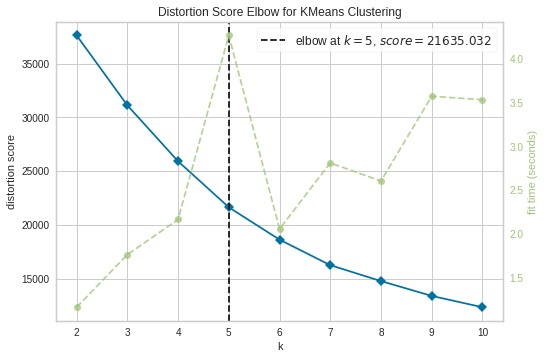

In [ ]:
X = data.copy()

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

**Coefficient de silhouette**

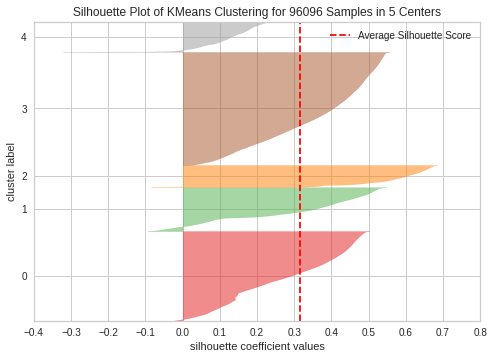

In [ ]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

**Distances intercluster**

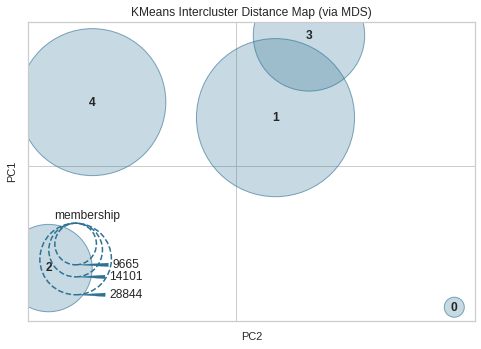

In [ ]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster

**Analyse des différents clusters**

In [ ]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data["kmeans_label"] = kmeans_labels

In [ ]:
kmeans_clusters_means = data.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,other,sport,technology,total_items,order_mean_delay,r_score,f_score,m_score,freight_ratio,harvesine_distance
0,0,0.909539,145.207211,1.046554,2.945243,4.679481,11.579230,0.000017,0.000118,0.000084,...,0.999601,0.000104,0.000035,1.021220,376.670015,377.729968,1.021220,151.993044,0.202608,449.192991
1,1,1.037546,154.394741,1.034242,2.473912,4.235925,12.261376,0.000000,0.000658,0.000035,...,0.004112,0.994532,0.000233,1.165453,239.190803,245.215887,1.165453,149.299047,0.198942,427.212864
2,2,1.056121,164.448906,1.039293,2.813024,4.703833,10.533889,0.000018,0.000939,0.000588,...,0.995804,0.001567,0.000258,1.183274,114.318934,120.467345,1.183274,156.554227,0.210609,409.366886
3,3,1.023073,158.162173,1.050055,3.101902,4.239812,12.246531,0.006648,0.221266,0.353578,...,0.004386,0.000775,0.109053,1.099741,273.390472,277.578893,1.099741,154.940371,0.186458,451.662938
4,4,1.032549,186.022147,1.042305,3.176675,1.758101,18.835360,0.000000,0.000945,0.001267,...,0.995254,0.001741,0.000201,1.331797,219.682060,224.943341,1.331797,181.111143,0.217446,485.350877


In [ ]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=numerical_features)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,books_cds_media,fashion_clothing_accessories,flowers_gifts,health_beauty,other,sport,technology,total_items,order_mean_delay,r_score,f_score,m_score,freight_ratio,harvesine_distance
kmeans_label,,,,,,,,,,,,,,,,,,,,
0,0.060636,0.010627,0.001862,0.113279,0.919870,0.050618,0.000017,0.000118,0.000084,0.000040,0.999601,0.000104,0.000035,0.042551,0.541971,0.544279,0.042551,0.010429,0.211050,0.172144
1,0.069170,0.011299,0.001370,0.095150,0.808981,0.053882,0.000000,0.000658,0.000035,0.000430,0.004112,0.994532,0.000233,0.048561,0.344159,0.353337,0.048561,0.010232,0.207232,0.161036
2,0.070408,0.012035,0.001572,0.108193,0.925958,0.045617,0.000018,0.000939,0.000588,0.000825,0.995804,0.001567,0.000258,0.049303,0.164488,0.173584,0.049303,0.010763,0.219384,0.152017
3,0.068205,0.011575,0.002002,0.119304,0.809953,0.053811,0.006648,0.221266,0.353578,0.304294,0.004386,0.000775,0.109053,0.045823,0.393368,0.399970,0.045823,0.010645,0.194227,0.173392
4,0.068837,0.013614,0.001692,0.122180,0.189525,0.085337,0.000000,0.000945,0.001267,0.000591,0.995254,0.001741,0.000201,0.055492,0.316089,0.324126,0.055492,0.012562,0.226506,0.190417


In [ ]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

Le poids des features de catégories de produits masque les autres axes de catégorisation, nous allons donc réaliser un nouveau K-Means en supprimant ces variables

**Clustering sans les catégories produits**


In [ ]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'health_beauty',
                  'other',
                  'sport',
                  'technology']
X_bis = X.drop(categories_col, axis=1)
''' X_bis.head(3) '''
''' 'groceries_food_drink',
'home_furniture',
'toys_baby' '''

" 'groceries_food_drink',\n'home_furniture',\n'toys_baby' "

In [ ]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

In [ ]:
#drop favorite_sale_month
X_bis = X_bis.drop('favorite_sale_month', axis=1)

In [ ]:
numerical_features = list(X_bis.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['nb_orders',
 'total_spend',
 'mean_payment_sequential',
 'mean_payment_installments',
 'mean_review_score',
 'mean_delivery_days',
 'total_items',
 'order_mean_delay',
 'r_score',
 'f_score',
 'm_score',
 'freight_ratio',
 'harvesine_distance']

In [ ]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

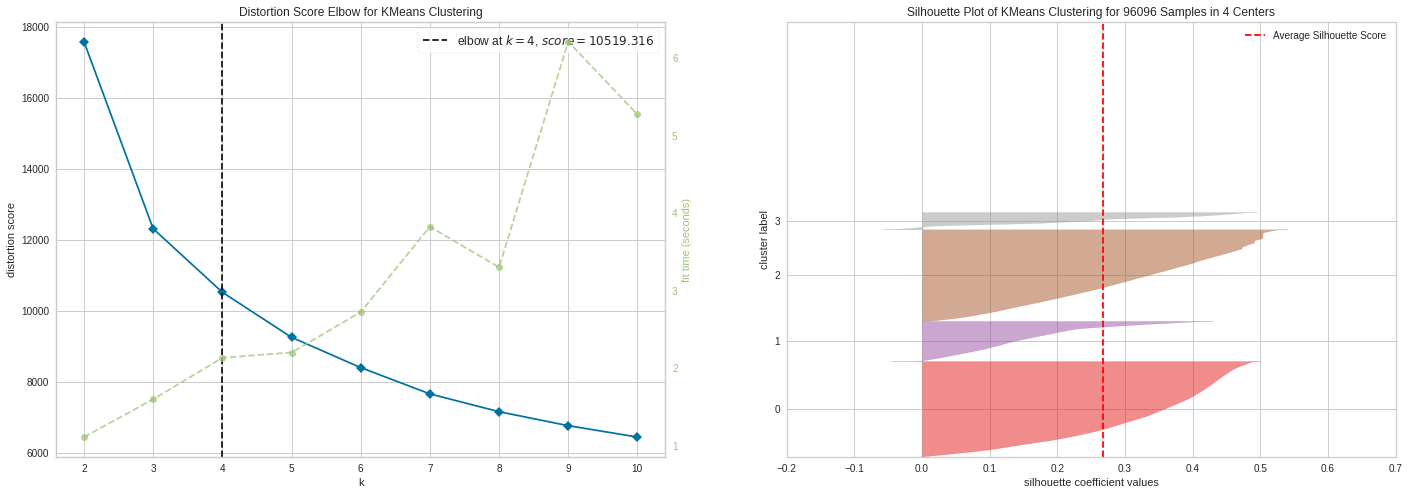

In [ ]:
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_bis, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None)

In [ ]:
X_bis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   nb_orders                  96096 non-null  int64  
 1   total_spend                96096 non-null  float64
 2   mean_payment_sequential    96096 non-null  float64
 3   mean_payment_installments  96096 non-null  float64
 4   mean_review_score          96096 non-null  float64
 5   mean_delivery_days         96096 non-null  float64
 6   total_items                96096 non-null  float64
 7   order_mean_delay           96096 non-null  float64
 8   r_score                    96096 non-null  float64
 9   f_score                    96096 non-null  int64  
 10  m_score                    96096 non-null  float64
 11  freight_ratio              96096 non-null  float64
 12  harvesine_distance         96096 non-null  float6

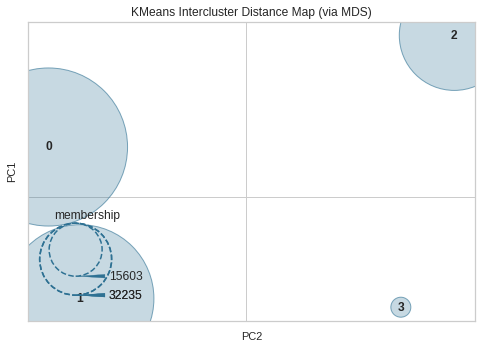

' X_bis.head() '

In [ ]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])

distance_visualizer.fit(X_bis)
distance_visualizer.named_steps['distancevisualizer'].show()
''' X_bis.head() '''

In [ ]:
# KMeans Pipeline with best K
kmeans_model_bis = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_bis.fit(X_bis)

# Kmeans labels
kmeans_labels_bis = kmeans_model_bis.named_steps['kmeans'].labels_
X_bis['kmeans_label'] = kmeans_labels_bis





In [ ]:
kmeans_clusters_means_bis = X_bis.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means_bis

,kmeans_label,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,total_items,order_mean_delay,r_score,f_score,m_score,freight_ratio,harvesine_distance
0,0,0.982553,192.016704,1.046526,3.322710,4.534009,18.192188,1.076815,241.236728,245.804801,1.076815,190.638154,0.265954,1393.111105
1,1,1.029067,183.040290,1.044833,3.141198,1.671153,18.948740,1.317562,227.329081,232.247199,1.317562,178.803482,0.212416,450.127362
2,2,1.057290,159.051610,1.037006,2.737725,4.694109,9.795905,1.181491,114.801781,121.432712,1.181491,151.130176,0.200784,314.316345
3,3,0.931765,142.891424,1.047434,2.900671,4.677028,10.799860,1.039563,381.576292,382.588047,1.039563,147.995204,0.193178,331.574051


In [ ]:
# Scale X
scaler = MinMaxScaler()
X_scaled_bis = scaler.fit_transform(X_bis)
X_scaled_bis = pd.DataFrame(X_scaled_bis, index=X_bis.index, columns=X_bis.columns)
X_scaled_bis["kmeans_label"] = kmeans_labels_bis

# Group by cluster
X_scaled_clusters_bis = X_scaled_bis.groupby("kmeans_label").mean()
X_scaled_clusters_bis

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,total_items,order_mean_delay,r_score,f_score,m_score,freight_ratio,harvesine_distance
kmeans_label,,,,,,,,,,,,,
0,0.065504,0.014053,0.001861,0.127797,0.883502,0.082259,0.044867,0.347103,0.354186,0.044867,0.013259,0.277036,0.649164
1,0.068604,0.013396,0.001793,0.120815,0.167788,0.085879,0.054898,0.327092,0.334650,0.054898,0.012393,0.221266,0.172616
2,0.070486,0.011640,0.001480,0.105297,0.923527,0.042086,0.049229,0.165182,0.174975,0.049229,0.010366,0.209150,0.103983
3,0.062118,0.010457,0.001897,0.111564,0.919257,0.046889,0.043315,0.549031,0.551280,0.043315,0.010136,0.201227,0.112704


In [ ]:
# Plot Radar chart
plot_radars(data=X_scaled_clusters_bis,
            group="kmeans_label")

**Interpretation**